<a href="https://colab.research.google.com/github/NicoAN42/SKRPSI/blob/main/amitofooo_cbam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount dataset
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from tensorflow.keras.layers import Conv2D, Input, concatenate, Activation, InputLayer, Dense, Reshape, Flatten, Add, multiply, Permute, Lambda, Concatenate
from tensorflow.keras.layers import LeakyReLU,ReLU, MaxPooling2D, BatchNormalization,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.activations import softmax,sigmoid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout,SpatialDropout2D,GaussianDropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras import backend as K
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import os
import random
import shutil

In [3]:
from tensorflow.keras.optimizers import SGD

In [4]:
CLASS = 3
#sourcepath isi semua data train, folder valid kosongin datanya sisai folder classnya
sourcePath = '/content/drive/MyDrive/Colab Notebooks/Dataset 007'
train_path = '/content/drive/MyDrive/Colab Notebooks/Dataset 007/train'
valid_path = '/content/drive/MyDrive/Colab Notebooks/Dataset 007/valid'
test_path = '/content/drive/MyDrive/Colab Notebooks/Dataset 007/test'

#nico

In [5]:
classLabels =['covid','normal', 'pneumonia']

In [6]:
def attach_attention_module(net, attention_module):
  #if attention_module == 'se_block': # SE_block
    #net = se_block(net)
  if attention_module == 'cbam_block': # CBAM_block
    net = cbam_block(net)
  else:
    raise Exception("'{}' is not supported attention module!".format(attention_module))

  return net

In [7]:
def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature


In [8]:
def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

In [9]:
def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])

In [10]:
input = Input(shape=(256,256,3))

In [11]:
#Layer 1
model = layers.Conv2D(32, (3,3), padding='same', name='conv_1', activation = 'relu')(input)
model = layers.BatchNormalization(name='norm_1')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides= 2)(model)


In [12]:
#Layer 2
model = layers.Conv2D(64, (3,3), padding='same', name='conv_2', activation = 'relu')(model)
model = layers.Dropout(0.1)(model)
model = layers.BatchNormalization(name='norm_2')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)

In [13]:
# Layer 3
model = layers.Conv2D(64, (3,3), padding='same', name='conv_3', activation = 'relu')(model)
model = layers.BatchNormalization(name='norm_3')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)


In [14]:
# Layer 4
model = layers.Conv2D(128, (3,3), padding='same', name='conv_4', activation = 'relu')(model)
model = layers.Dropout(0.2)(model)
model = layers.BatchNormalization(name='norm_4')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)


In [15]:
# Layer 5
model = layers.Conv2D(256, (3,3), padding='same', name='conv_5', activation = 'relu')(model)
layer = layers.Conv2D(256, (3,3), padding='same', name='conv_5', activation = 'relu')
batch = layers.BatchNormalization(name='norm_5')
model = layers.Dropout(0.2)(model)
model = layers.BatchNormalization(name='norm_5')(model)
#model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)
attention_module = 'cbam_block'
y = attach_attention_module(model, attention_module)
model =  tensorflow.keras.layers.add([model, y])

In [16]:
model = layers.Flatten()(model)
model = layers.Dense(128, activation = 'relu')(model)
model = layers.Dropout(0.2)(model)
output = layers.Dense(3,Activation('softmax'))(model)
model = Model(input, output)

In [17]:
#output = model.output_shape

In [18]:
print(input)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [19]:
initial_learning_rate=0.0001

In [20]:
lr_schedule = ExponentialDecay(
   initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


In [21]:
opt = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [22]:
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )

In [23]:
print(model.summary())
print(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 norm_1 (BatchNormalization)    (None, 256, 256, 32  128         ['conv_1[0][0]']                 
                                )                                                             

In [24]:
X = []
Y = []
def transferBetweenFolders(source, dest, splitRate): 
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        

In [25]:
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(sourcePath+'/'+source+'/'+label+'/', 
                               sourcePath+'/'+dest+'/'+label+'/', 
                               splitRate)
        

In [26]:
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(sourcePath+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(classLabels)):
          if(folderName==classLabels[i]):
              Y.append(i)
# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
  prepareNameWithLabels(classLabels[i])

def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

In [27]:
X=np.asarray(X)
Y=np.asarray(Y)

print(X)
print(Y)

skf = StratifiedKFold(n_splits=4
                      , shuffle=True)
skf.get_n_splits(X, Y)
foldNum=0

['COVID(935).png' 'COVID(578).png' 'COVID(331).png' ...
 'person1361_bacteria_3476.jpeg' 'person1377_bacteria_3512.jpeg'
 'person1371_virus_2361.jpeg']
[0 0 0 ... 2 2 2]


Results for fold 1
Found 1830 images belonging to 3 classes.
Found 475 images belonging to 3 classes.
Found 410 images belonging to 3 classes.
Epoch 1/100
29/29 - 494s - loss: 1.3165 - accuracy: 0.8765 - val_loss: 7.2023 - val_accuracy: 0.5832 - 494s/epoch - 17s/step
Epoch 2/100
29/29 - 23s - loss: 0.1336 - accuracy: 0.9541 - val_loss: 0.6633 - val_accuracy: 0.7326 - 23s/epoch - 808ms/step
Epoch 3/100
29/29 - 24s - loss: 0.0927 - accuracy: 0.9705 - val_loss: 0.5405 - val_accuracy: 0.8147 - 24s/epoch - 813ms/step
Epoch 4/100
29/29 - 23s - loss: 0.0630 - accuracy: 0.9798 - val_loss: 0.2387 - val_accuracy: 0.9284 - 23s/epoch - 807ms/step
Epoch 5/100
29/29 - 23s - loss: 0.0247 - accuracy: 0.9918 - val_loss: 0.1489 - val_accuracy: 0.9579 - 23s/epoch - 805ms/step
Epoch 6/100
29/29 - 23s - loss: 0.0904 - accuracy: 0.9743 - val_loss: 0.2487 - val_accuracy: 0.9326 - 23s/epoch - 808ms/step
Epoch 7/100
29/29 - 23s - loss: 0.0523 - accuracy: 0.9776 - val_loss: 0.0822 - val_accuracy: 0.9747 - 23s/e

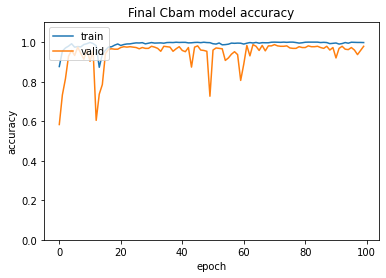

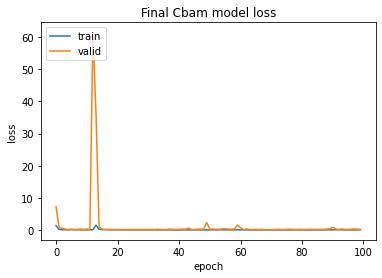

0.0393
***Performance on Validation data***
Accuracy  : 0.9585365853658536
Precision : 0.9588174092951489
f1Score : 0.9582549802113046
[[133   0   2]
 [  1 137   2]
 [  5   7 123]]
7/7 [==============================] - 4s 609ms/step - loss: 0.3819 - accuracy: 0.9585
Results for fold 2
Found 1830 images belonging to 3 classes.
Found 475 images belonging to 3 classes.
Found 410 images belonging to 3 classes.
Epoch 1/100
29/29 - 24s - loss: 0.0783 - accuracy: 0.9902 - val_loss: 0.0428 - val_accuracy: 0.9832 - 24s/epoch - 837ms/step
Epoch 2/100
29/29 - 23s - loss: 0.1140 - accuracy: 0.9820 - val_loss: 0.2058 - val_accuracy: 0.9537 - 23s/epoch - 806ms/step
Epoch 3/100
29/29 - 23s - loss: 0.0668 - accuracy: 0.9863 - val_loss: 0.3235 - val_accuracy: 0.9179 - 23s/epoch - 810ms/step
Epoch 4/100
29/29 - 23s - loss: 0.0305 - accuracy: 0.9923 - val_loss: 0.3441 - val_accuracy: 0.9179 - 23s/epoch - 797ms/step
Epoch 5/100
29/29 - 23s - loss: 0.0268 - accuracy: 0.9934 - val_loss: 0.2900 - val_accura

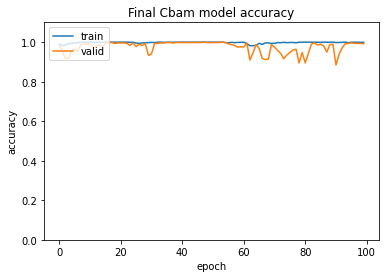

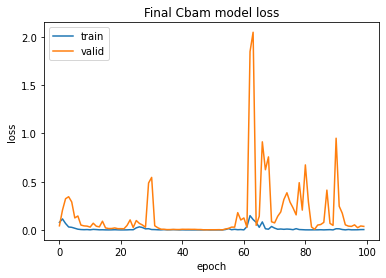

0.0386
***Performance on Validation data***
Accuracy  : 0.9414634146341463
Precision : 0.9416001380911234
f1Score : 0.941112538159055
[[131   0   4]
 [  2 135   3]
 [  5  10 120]]
7/7 [==============================] - 4s 622ms/step - loss: 0.6545 - accuracy: 0.9415
Results for fold 3
Found 1830 images belonging to 3 classes.
Found 475 images belonging to 3 classes.
Found 410 images belonging to 3 classes.
Epoch 1/100
29/29 - 24s - loss: 0.0133 - accuracy: 0.9978 - val_loss: 0.1250 - val_accuracy: 0.9600 - 24s/epoch - 834ms/step
Epoch 2/100
29/29 - 23s - loss: 0.0066 - accuracy: 0.9973 - val_loss: 0.0432 - val_accuracy: 0.9853 - 23s/epoch - 809ms/step
Epoch 3/100
29/29 - 24s - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0060 - val_accuracy: 0.9958 - 24s/epoch - 817ms/step
Epoch 4/100
29/29 - 23s - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0100 - val_accuracy: 0.9958 - 23s/epoch - 805ms/step
Epoch 5/100
29/29 - 24s - loss: 0.0023 - accuracy: 0.9989 - val_loss: 0.0045 - val_accurac

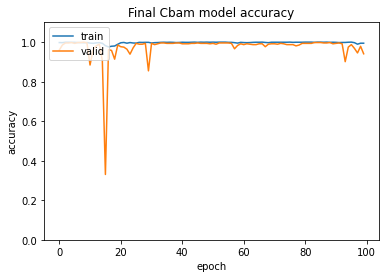

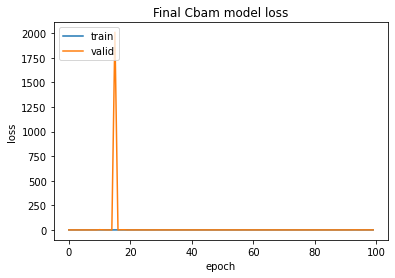

0.0365
***Performance on Validation data***
Accuracy  : 0.8902439024390244
Precision : 0.9015338223430359
f1Score : 0.8847184858084487
[[134   0   1]
 [  1 138   1]
 [ 21  21  93]]
7/7 [==============================] - 4s 620ms/step - loss: 1.0292 - accuracy: 0.8902
Results for fold 4
Found 1830 images belonging to 3 classes.
Found 475 images belonging to 3 classes.
Found 410 images belonging to 3 classes.
Epoch 1/100
29/29 - 24s - loss: 0.0471 - accuracy: 0.9913 - val_loss: 0.0366 - val_accuracy: 0.9874 - 24s/epoch - 841ms/step
Epoch 2/100
29/29 - 24s - loss: 0.0425 - accuracy: 0.9913 - val_loss: 0.2501 - val_accuracy: 0.9389 - 24s/epoch - 822ms/step
Epoch 3/100
29/29 - 24s - loss: 0.0124 - accuracy: 0.9940 - val_loss: 0.0233 - val_accuracy: 0.9937 - 24s/epoch - 818ms/step
Epoch 4/100
29/29 - 24s - loss: 0.0347 - accuracy: 0.9967 - val_loss: 0.0128 - val_accuracy: 0.9958 - 24s/epoch - 826ms/step
Epoch 5/100
29/29 - 24s - loss: 0.0087 - accuracy: 0.9962 - val_loss: 0.0594 - val_accura

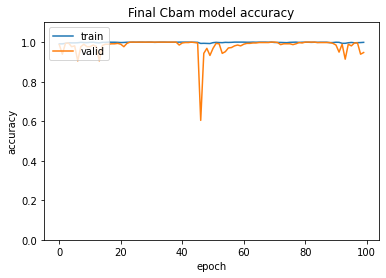

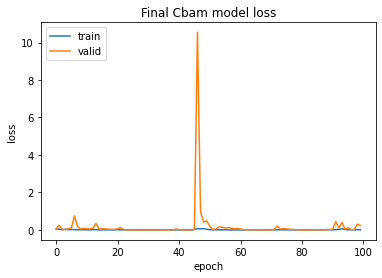

0.0376
***Performance on Validation data***
Accuracy  : 0.9170731707317074
Precision : 0.9231160023993827
f1Score : 0.9171233168042234
[[132   0   3]
 [  2 118  20]
 [  8   1 126]]
7/7 [==============================] - 4s 629ms/step - loss: 0.8445 - accuracy: 0.9171


In [28]:
for train_index, val_index in skf.split(X, Y):
    #First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('valid', 'train', 1.0)
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    # Move validation images of this fold from train folder to the validation folder
    for eachIndex in range(len(X_val)):
        classLabel=''
        for i in range(len(classLabels)):
          if(Y_val[eachIndex]==i):
              classLabel=classLabels[i]
        #Then, copy the validation images to the validation folder
        shutil.move(sourcePath+'/train/'+classLabel+'/'+X_val[eachIndex], 
                    sourcePath+'/valid/'+classLabel+'/'+X_val[eachIndex])
        
    train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 64, shuffle=True)
    valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 64, shuffle=True)
    test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 64, shuffle=False)

    history = model.fit(train_batches, 
                    #steps_per_epoch=sp_epoch, 
                    validation_data=valid_batches, 
                    #validation_steps=10, 
                    epochs=100, 
                    verbose=2)
    
    
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Final Cbam model accuracy')
    plt.ylim(0,1.1)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Final Cbam model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    test_batches.reset()
    Y_pred = model.predict(test_batches)
    classes = test_batches.classes[test_batches.index_array]
    y_pred = np.argmax(Y_pred, axis=-1)
    print(sum(y_pred==classes)/10000)
    confusion_matrix(test_batches.classes[test_batches.index_array],y_pred)
    #predictions = model.predict(test_batches, verbose=1)
    #yPredictions = np.argmax(predictions, axis=1)
    #print(yPredictions)
    #true_classes = test_batches.classes
    # evaluate validation performance
    print("***Performance on Validation data***")    
    #valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)
    valAcc, valPrec, valFScore = my_metrics(classes, y_pred)

    model.evaluate(test_batches)